In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [31]:
def train_test_classification_reports(y_train, y_hat_train, y_test, y_hat_test):
    print('_'*10 + 'TRAIN SCORES' + '_'*10)
    print(classification_report(y_train, y_hat_train))
    print('-'*30, end='\n\n')
    print('_'*10 + 'TEST SCORES' + '_'*10)
    print(classification_report(y_test, y_hat_test))
    print('-'*30, end='\n\n')
    

In [29]:
def train_test_confusion_matrices(y_train, y_hat_train, y_test, y_hat_test):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    sns.heatmap(data=confusion_matrix(y_train, y_hat_train),
                cmap='Blues',
                annot=True,
                xticklabels=labels,
                yticklabels=labels,
                annot_kws=annot_kws,
                fmt='.2f',
                ax=axes[0]
    )
    axes[0].set_title('TRAIN', fontdict=title_font)
    axes[0].set_xlabel('Predicted Label', fontdict=axis_font)
    axes[0].set_ylabel('True Label', fontdict=axis_font)


    sns.heatmap(data=confusion_matrix(y_test, y_hat_test),
                cmap='Reds',
                annot=True,
                xticklabels=labels,
                yticklabels=labels,
                annot_kws=annot_kws,
                fmt='.2f',
                ax=axes[1]

    )
    axes[1].set_title('TEST', fontdict=title_font)
    axes[1].set_xlabel('Predicted Label', fontdict=axis_font)
    axes[1].set_ylabel('True Label', fontdict=axis_font)

    fig.tight_layout();

In [2]:
BIN_FIELDS = ['INTERSECTION_RELATED_I',
              'HIT_AND_RUN_I',
              'WORK_ZONE_I']
CAT_FIELDS = ['TRAFFIC_CONTROL_DEVICE',
              'DEVICE_CONDITION',
              'WEATHER_CONDITION',
              'LIGHTING_CONDITION',
              'FIRST_CRASH_TYPE',
              'TRAFFICWAY_TYPE',
              'ALIGNMENT',
              'ROADWAY_SURFACE_COND',
              'ROAD_DEFECT',
              'CRASH_TYPE',
              'DAMAGE',
              'MOST_SEVERE_INJURY',
              'CRASH_HOUR',
              'CRASH_DAY_OF_WEEK',
              'CRASH_MONTH',
              'CRASH_YEAR']
NUM_FIELDS = ['POSTED_SPEED_LIMIT',
              'NUM_UNITS',
              'INJURIES_TOTAL',
              'INJURIES_FATAL',
              'LATITUDE',
              'LONGITUDE']
TARGET = 'PRIM_CONTRIBUTORY_CAUSE'
ID = 'CRASH_ID'

with open('pipelines/binned_causes.pkl', 'rb') as f:
    BINNED_CAUSES = pickle.load(f)


In [3]:
crashes = pd.read_pickle('data/crashes.pkl')
crashes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301934 entries, 0 to 526552
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_RECORD_ID          301934 non-null  object 
 1   CRASH_YEAR               301934 non-null  int64  
 2   POSTED_SPEED_LIMIT       301934 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE   294593 non-null  object 
 4   DEVICE_CONDITION         288120 non-null  object 
 5   WEATHER_CONDITION        295279 non-null  object 
 6   LIGHTING_CONDITION       298364 non-null  object 
 7   FIRST_CRASH_TYPE         301934 non-null  object 
 8   TRAFFICWAY_TYPE          291675 non-null  object 
 9   ALIGNMENT                301934 non-null  object 
 10  ROADWAY_SURFACE_COND     289533 non-null  object 
 11  ROAD_DEFECT              263625 non-null  object 
 12  CRASH_TYPE               301934 non-null  object 
 13  INTERSECTION_RELATED_I   85281 non-null   object 
 14  HIT_

In [4]:
rng = np.random.RandomState(42)

X = crashes.drop('PRIM_CONTRIBUTORY_CAUSE', axis=1)
y = crashes['PRIM_CONTRIBUTORY_CAUSE'].map(BINNED_CAUSES)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng, test_size=0.20)
# stratify to y maintain proportion of imbalances

In [5]:
print(y_train.value_counts(dropna=False))
print()
print(y_test.value_counts(dropna=False))

DRIVER                209703
ENVIRONMENT            17624
DISREGARDING_SIGNS     14220
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64

DRIVER                52609
ENVIRONMENT            4255
DISREGARDING_SIGNS     3523
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64


In [ ]:
# Add dummy classifier for baseline

In [51]:
bin_imputer = SimpleImputer(strategy='constant', fill_value=False)
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='most_frequent')

imputers = ColumnTransformer([
    ('binary', bin_imputer, BIN_FIELDS),
    ('categorical', cat_imputer, CAT_FIELDS),
    ('numeric', num_imputer, NUM_FIELDS)
])

ohe = OneHotEncoder(handle_unknown='ignore')

model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4,
    random_state=rng,
)

feat_pipeline = Pipeline([
    ('imputers', imputers),
    ('encoder', ohe),
    ('model', model)
])

In [7]:
feat_pipeline.fit(X_train, y_train)
y_hat_train = feat_pipeline.predict(X_train)
y_hat_test = feat_pipeline.predict(X_test)

print('-'*10 + 'TRAIN' + '-'*10)
print(classification_report(y_train, y_hat_train))

----------TRAIN----------
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.62      0.42      0.50     14220
            DRIVER       0.90      0.98      0.94    209703
       ENVIRONMENT       0.61      0.14      0.23     17624

          accuracy                           0.88    241547
         macro avg       0.71      0.51      0.56    241547
      weighted avg       0.86      0.88      0.86    241547



In [8]:
print('-'*10 + 'TEST' + '-'*10)
print(classification_report(y_test, y_hat_test))

----------TEST----------
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.59      0.40      0.48      3523
            DRIVER       0.90      0.98      0.94     52609
       ENVIRONMENT       0.61      0.15      0.24      4255

          accuracy                           0.88     60387
         macro avg       0.70      0.51      0.55     60387
      weighted avg       0.86      0.88      0.86     60387



In [9]:
labels = ['DISREGARDING_SIGNS', 'DRIVER', 'ENVIRONMENT']
title_font = {
    'family': 'serif',
    'size': 20,
    'weight': 'bold'
}

axis_font = {
    'family': 'serif',
    'size': 16, 
    'weight': 'bold'
}
annot_kws = {
    'family': 'serif',
    'size': 14
}

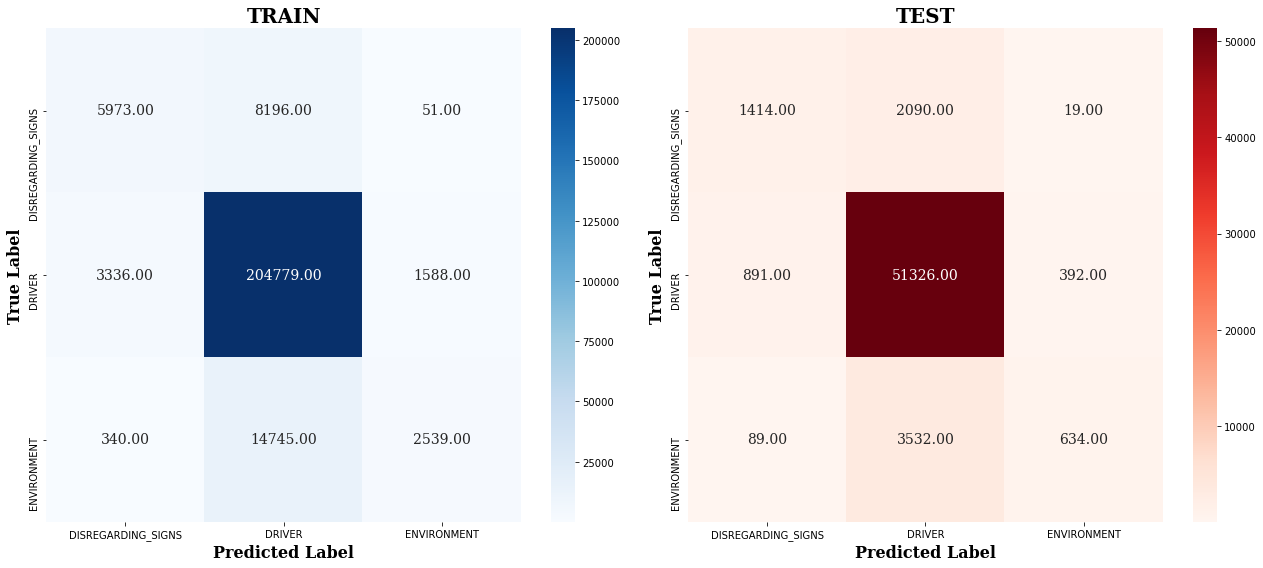

In [35]:
train_test_confusion_matrices(y_train, y_hat_train, y_test, y_hat_test)

In [37]:
train_test_classification_reports(y_train, y_hat_train, y_test, y_hat_test)

__________TRAIN SCORES__________
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.62      0.42      0.50     14220
            DRIVER       0.90      0.98      0.94    209703
       ENVIRONMENT       0.61      0.14      0.23     17624

          accuracy                           0.88    241547
         macro avg       0.71      0.51      0.56    241547
      weighted avg       0.86      0.88      0.86    241547

------------------------------

__________TEST SCORES__________
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.59      0.40      0.48      3523
            DRIVER       0.90      0.98      0.94     52609
       ENVIRONMENT       0.61      0.15      0.24      4255

          accuracy                           0.88     60387
         macro avg       0.70      0.51      0.55     60387
      weighted avg       0.86      0.88      0.86     60387

------------------------------



In [24]:
smote = SMOTE(random_state=rng)

In [25]:
smote_pipeline = Pipeline(steps=[
    ('imputers', imputers),
    ('encoder', ohe),
    ('smote', smote),
    ('model', model)
])

In [28]:
smote_pipeline.fit(X_train, y_train)
y_hat_train_smote = smote_pipeline.predict(X_train)
y_hat_test_smote = smote_pipeline.predict(X_test)

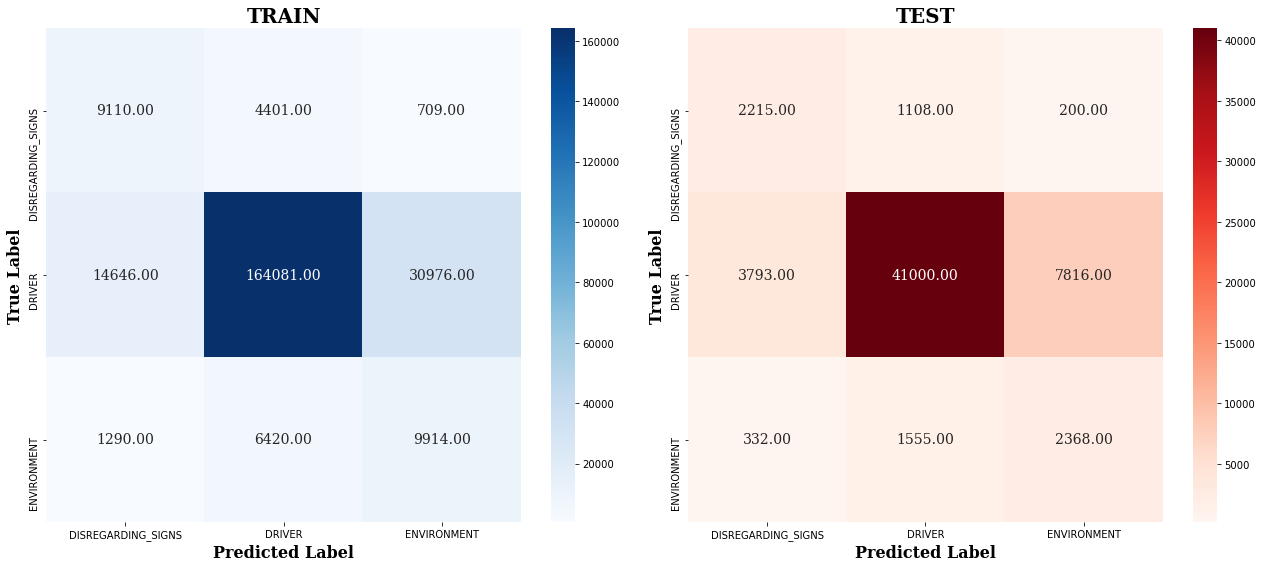

In [30]:
train_test_confusion_matrices(y_train, y_hat_train_smote, y_test, y_hat_test_smote)

In [34]:
train_test_classification_reports(y_train, y_hat_train_smote, y_test, y_hat_test_smote)

__________TRAIN SCORES__________
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.36      0.64      0.46     14220
            DRIVER       0.94      0.78      0.85    209703
       ENVIRONMENT       0.24      0.56      0.33     17624

          accuracy                           0.76    241547
         macro avg       0.51      0.66      0.55    241547
      weighted avg       0.85      0.76      0.79    241547

------------------------------

__________TEST SCORES__________
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.35      0.63      0.45      3523
            DRIVER       0.94      0.78      0.85     52609
       ENVIRONMENT       0.23      0.56      0.32      4255

          accuracy                           0.75     60387
         macro avg       0.51      0.65      0.54     60387
      weighted avg       0.85      0.75      0.79     60387

------------------------------



In [44]:
# Just crashes involving injuries
crashes_injuries = pd.read_pickle('data/crashes_injuries.pkl')
crashes_injuries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33003 entries, 7 to 526544
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CRASH_RECORD_ID          33003 non-null  object 
 1   CRASH_YEAR               33003 non-null  int64  
 2   POSTED_SPEED_LIMIT       33003 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE   32372 non-null  object 
 4   DEVICE_CONDITION         31522 non-null  object 
 5   WEATHER_CONDITION        32622 non-null  object 
 6   LIGHTING_CONDITION       32859 non-null  object 
 7   FIRST_CRASH_TYPE         33003 non-null  object 
 8   TRAFFICWAY_TYPE          32075 non-null  object 
 9   ALIGNMENT                33003 non-null  object 
 10  ROADWAY_SURFACE_COND     32227 non-null  object 
 11  ROAD_DEFECT              29483 non-null  object 
 12  CRASH_TYPE               33003 non-null  object 
 13  INTERSECTION_RELATED_I   15861 non-null  object 
 14  HIT_AND_RUN_I        

In [55]:
X = crashes_injuries.drop('PRIM_CONTRIBUTORY_CAUSE', axis=1)
y = crashes_injuries['PRIM_CONTRIBUTORY_CAUSE'].map(BINNED_CAUSES)
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y, random_state=rng, test_size=0.2)

In [56]:
fitted_injuries = feat_pipeline.fit(X_train_i, y_train_i)

In [57]:
y_hat_train_i = fitted_injuries.predict(X_train_i)
y_hat_test_i = fitted_injuries.predict(X_test_i)

In [58]:
train_test_classification_reports(y_train_i, y_hat_train_i, y_test_i, y_hat_test_i)

__________TRAIN SCORES__________
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.68      0.49      0.57      3659
            DRIVER       0.84      0.96      0.90     20734
       ENVIRONMENT       1.00      0.00      0.00      2009

          accuracy                           0.82     26402
         macro avg       0.84      0.48      0.49     26402
      weighted avg       0.83      0.82      0.78     26402

------------------------------

__________TEST SCORES__________
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.69      0.50      0.58       938
            DRIVER       0.84      0.96      0.90      5187
       ENVIRONMENT       0.00      0.00      0.00       476

          accuracy                           0.83      6601
         macro avg       0.51      0.49      0.49      6601
      weighted avg       0.76      0.83      0.79      6601

------------------------------



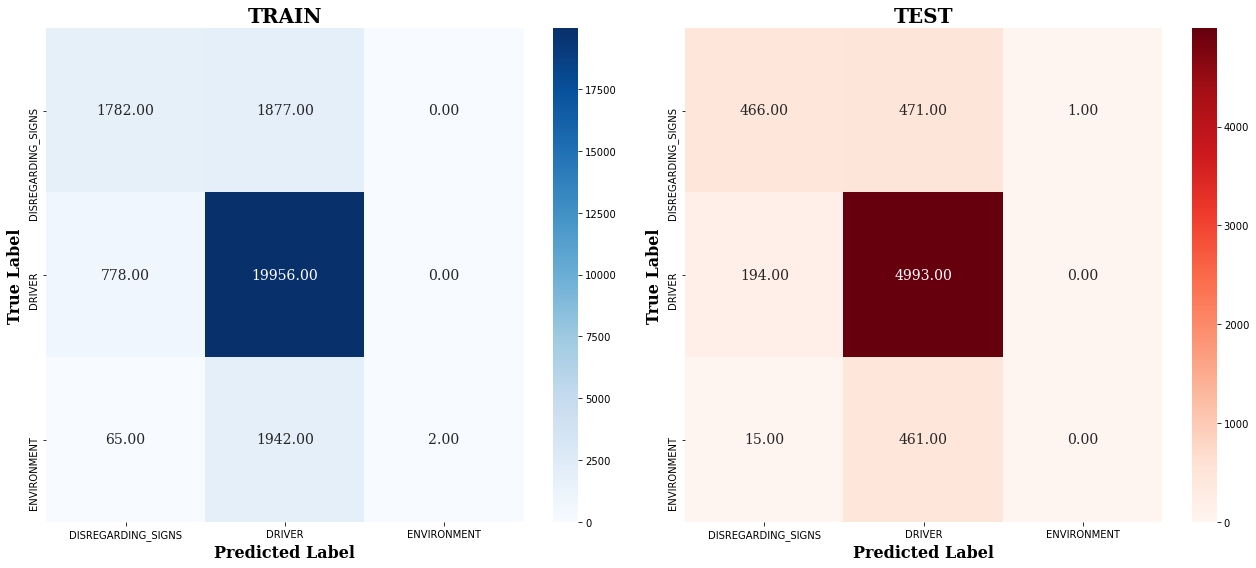

In [60]:
train_test_confusion_matrices(y_train_i, y_hat_train_i, y_test_i, y_hat_test_i)

In [61]:
smote_i = SMOTE(random_state=rng)

In [62]:
smote_pipeline_i = Pipeline(steps=[
    ('imputers', imputers),
    ('encoder', ohe),
    ('smote', smote),
    ('model', model)
])

In [67]:
smote_pipeline_i.fit(X_train_i, y_train_i)
y_hat_train_smote_i = smote_pipeline.predict(X_train_i)
y_hat_test_smote_i = smote_pipeline.predict(X_test_i)

In [68]:
train_test_classification_reports(y_train_i, y_hat_train_smote_i, y_test_i, y_hat_test_smote_i)

__________TRAIN SCORES__________


/Users/iansharff/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/iansharff/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                DISREGARDING STOP SIGN       0.00      0.00      0.00       0.0
          DISREGARDING TRAFFIC SIGNALS       0.00      0.00      0.00       0.0
                    DISREGARDING_SIGNS       0.00      0.00      0.00    3659.0
                                DRIVER       0.00      0.00      0.00   20734.0
                           ENVIRONMENT       0.00      0.00      0.00    2009.0
FAILING TO REDUCE SPEED TO AVOID CRASH       0.00      0.00      0.00       0.0
         FAILING TO YIELD RIGHT-OF-WAY       0.00      0.00      0.00       0.0
                 FOLLOWING TOO CLOSELY       0.00      0.00      0.00       0.0
                               WEATHER       0.00      0.00      0.00       0.0

                              accuracy                           0.00   26402.0
                             macro avg       0.00      0.00      0.00   26402.0
                          weighted avg

In [ ]:
train_test_confusion_matrices(y_train_i, y_hat_train_smote_i, y_test_i, y_hat_test_smote_i)